In [61]:
%run init_notebook.py

In [62]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [89]:
# Load data
model_type = "ols"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

year_start = 2011
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [90]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'

data compromises 10 years: 2764 lines


In [91]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)

data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))
data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [92]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     'sp_close_lag8',
     'sp_close_lag9',
     'sp_close_lag10'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     'weekday_1',
     'weekday_2',
     'weekday_3',
     'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [93]:
df_train = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [94]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.3,
                                            add_const=False)

# Sesonality

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [96]:
## SEASONALITY DF
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# filter for complete weeks only
_ = X_train_sea.groupby("week").weekday.count() == 5
_ = _[_].index
X_train_sea = X_train_sea[X_train_sea["week"].isin(_)]

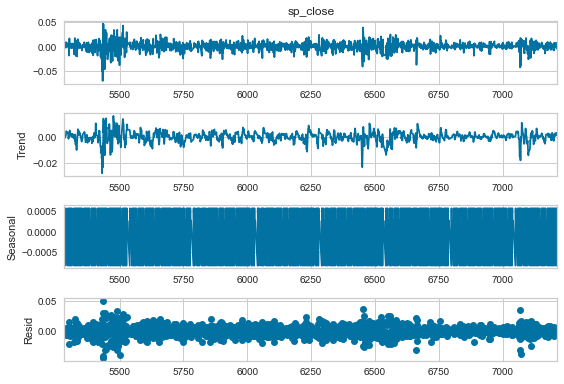

In [97]:
## SEASONALITY ANALYSIS
# create statsmodel seasonality object
sd = seasonal_decompose(X_train_sea.sp_close, period=5)
sd.plot()
plt.show()

In [98]:
# get seasonality by weekday
X_train_sea["seasonal"] = sd.seasonal
data_dict["model_features"].update(weekday_seasonality= dict(zip(X_train_sea.groupby("weekday").seasonal.first().index, X_train_sea.groupby("weekday").seasonal.first().values)))

In [99]:
# map sesonality to data
_ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

_ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

In [100]:
cols.append("seasonal")

# Corr

In [101]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Lag corr

In [102]:
df_cross_corr(X_train,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]],
              data_dict["model_features"]["predicted"],
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[['ff_M_RF', 4, 0.103],
 ['ff_SMB', 4, 0.054],
 ['ff_HML', 12, 0.058],
 ['ff_RMW', 4, 0.065],
 ['ff_CMA', 18, 0.039],
 ['weekday_1', 16, 0.034],
 ['weekday_2', 15, 0.032],
 ['weekday_3', 14, 0.034],
 ['weekday_4', 20, 0.029],
 ['seasonal', 12, 0.032]]

In [103]:
# X_train, _ = shift_var_relative_to_df(X_train,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# X_test, _ = shift_var_relative_to_df(X_test,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# data_dict["data_transformation"].update(shift_var=_)
# X_train = X_train.dropna()
# X_test = X_test.dropna()

Corr matrix

In [104]:
## ORTHOGONALISE
X_train = orthogonalise_vars(X_train, X="sp_close", y="ff_M_RF", show_fig=False)
X_train = orthogonalise_vars(X_train, X="ff_SMB", y="ff_M_RF", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close_lag4,1.027304,-0.098962
sp_close_lag2,1.031782,-0.054881
ff_HML,1.578225,-0.054039
sp_close,1.707470,-0.051062
sp_close_lag8,1.021681,-0.047920
seasonal,1.696362,-0.031661
ff_SMB,1.218997,-0.023280
weekday_4,1.141875,-0.018356
weekday_1,1.571257,-0.011146
weekday_3,1.015846,-0.005666


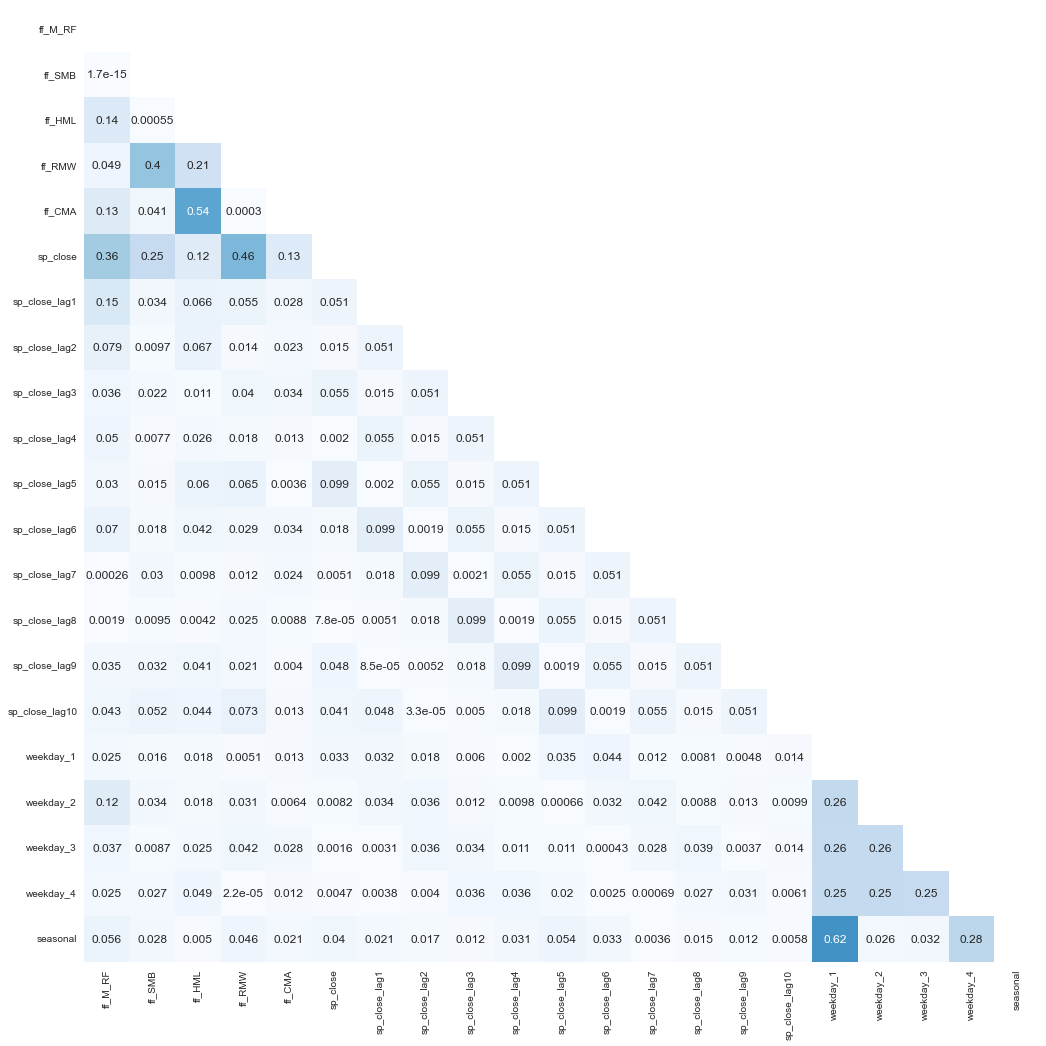

In [105]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [106]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [107]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [108]:
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)
model.results_.pvalues < .05

ff_M_RF           False
ff_SMB            False
ff_HML             True
ff_RMW            False
ff_CMA            False
sp_close          False
sp_close_lag1     False
sp_close_lag2      True
sp_close_lag3     False
sp_close_lag4      True
sp_close_lag5     False
sp_close_lag6     False
sp_close_lag7     False
sp_close_lag8      True
sp_close_lag9     False
sp_close_lag10    False
weekday_1         False
weekday_2         False
weekday_3         False
weekday_4         False
seasonal          False
intercept          True
dtype: bool

In [109]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.255
Date:                Mon, 21 Mar 2022   Prob (F-statistic):            0.00118
Time:                        16:15:47   Log-Likelihood:                 6398.2
No. Observations:                1935   AIC:                        -1.275e+04
Df Residuals:                    1914   BIC:                        -1.264e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ff_M_RF            0.0054      0.005      1.052      0.293      -0.005       0.016
ff_SMB            -0.0002      0.000     -0.512      0.609      -0.001       0.001
ff_HML            -0.0012      0.001     -2.181      0.029      -0.002      -0.000
ff_RMW          4.608e-05      0.001      0.063      0.950      -0.001       0.001
ff_CMA             0.0011      0.001      1.213      0.225      -0.001       0.003
sp_close          -0.0226      0.030     -0.767      0.443      -0.081       0.035
sp_close_lag1     -0.0015      0.023     -0.066      0.948      -0.047       0.044
sp_close_lag2     -0.0478      0.023     -2.084      0.037      -0.093      -0.003
sp_close_lag3     -0.0164      0.023     -0.715      0.474      -0.061       0.029
sp_close_lag4     -0.0958      0.023     -4.184      0.000      -0.141      -0.051
sp_close_lag5      0.0036      0.023      0.157      0.875      -0.042       0.049
sp_close_lag6   9.907e-05      0.023      0.004      0.997      -0.045       0.045
sp_close_lag7     -0.0133      0.023     -0.581      0.561      -0.058       0.032
sp_close_lag8     -0.0473      0.023     -2.070      0.039      -0.092      -0.002
sp_close_lag9      0.0294      0.023      1.285      0.199      -0.015       0.074
sp_close_lag10     0.0040      0.023      0.176      0.861      -0.041       0.049
weekday_1         -0.0008      0.001     -1.198      0.231      -0.002       0.000
weekday_2         -0.0007      0.001     -1.024      0.306      -0.002       0.001
weekday_3         -0.0008      0.001     -1.151      0.250      -0.002       0.001
weekday_4         -0.0010      0.001     -1.597      0.110      -0.002       0.000
seasonal       -4.349e-06   2.52e-06     -1.723      0.085    -9.3e-06       6e-07
intercept          0.0012      0.000      2.468      0.014       0.000       0.002
==============================================================================
Omnibus:                      381.719   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2296.432
Skew:                          -0.786   Prob(JB):                         0.00
Kurtosis:                       8.100   Cond. No.                     1.68e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.04e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Out of sample eval

In [110]:
# benchmark: mittelwert prognose - das ist ein random walk mit drift

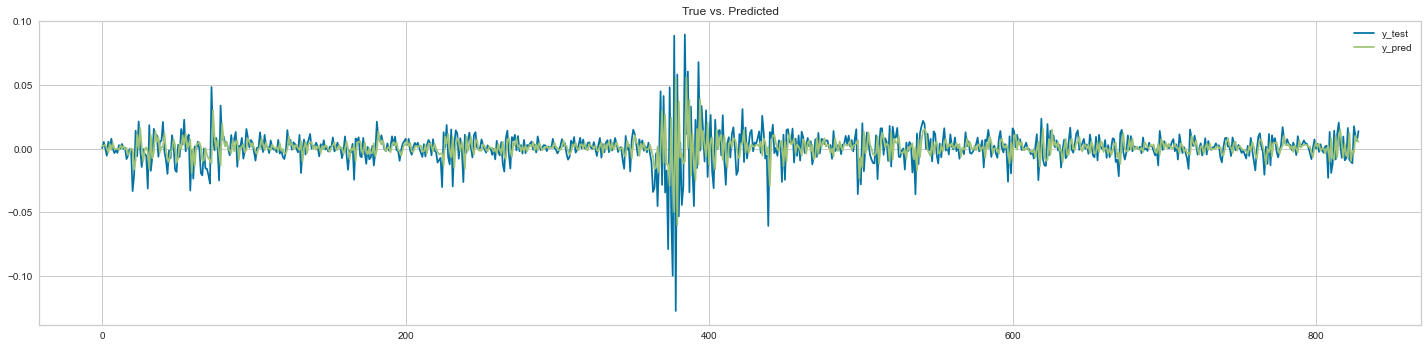

Validation Scores
root mean squared error: 0.0178846402
mean squared error: 0.0003198604
mean absolute error: 0.010533442
R2: -0.5817898107


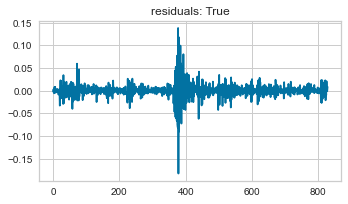

Stationarity Test Results
P-Values: 4.75794706069947e-10
Test-stats: -7.077572373169678
Time series is stationary: True


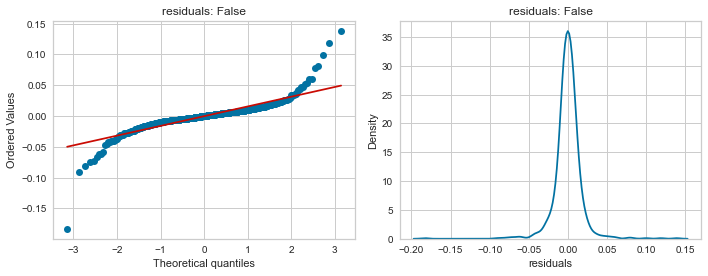

Normality Test Results
P-Values: 1.1617027106133899e-57
Test-stats: 262.19492703561974
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


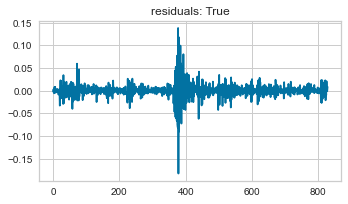

Test for Heteroskedasticity
Test p-value: 2.6317336025336276e-68
Heteroskedasticity is present: True


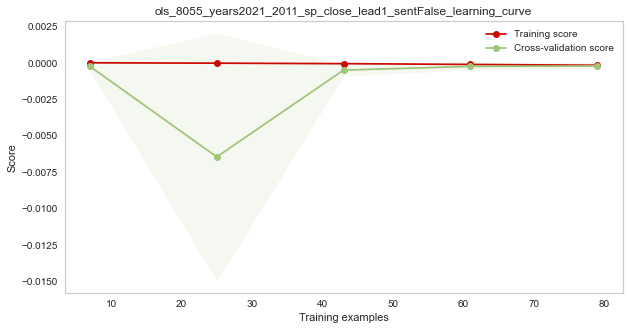

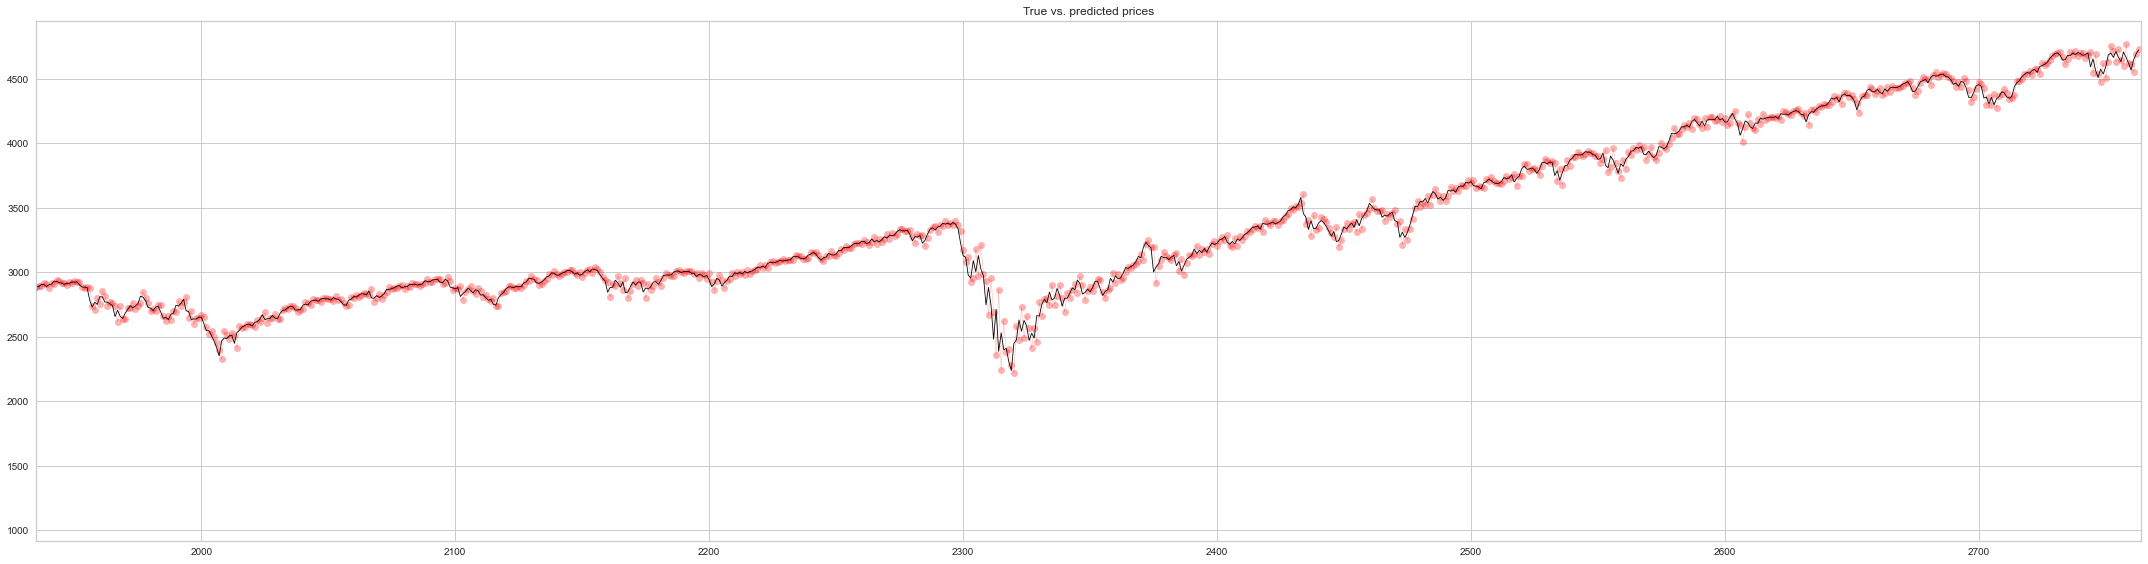

Validation Scores Test Data
mean squared error: 2728.0559620736
mean absolute error: 33.6137057002
mean absolute error in %: 0.014254660633385144
r2: 0.9933144288


In [111]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model,
            print_results=True)

fig_true_vs_fit = mval.get_model_performance()
stat, norm, hetero = mval.analyse_resids()

fig_lcurve = mval.sm_learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve", n_splits=10)
fig_prices = mval.plot_results_on_price_scale(df_w,
                                              df_train,
                                              sp_true_vals=data_dict["data"]["sp_true_vals"], show_pred_only=True)

# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [112]:
save_model(model, df_train, data_dict, fig_true_vs_fit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-21_ols_8055_years2021_2011_sp_close_lead1_sentFalse"? (y/n)


 y
